In [1]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 32
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
# https://github.com/jamesloyys/PyTorch-Lightning-GAN/blob/main/CGAN/cgan.py 
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding = nn.Embedding(10, 10)
        
        self.block1 = nn.Sequential(
            nn.Linear(in_features=self.latent_dim + 10, out_features=256),
            nn.BatchNorm1d(256)
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=512),
            nn.BatchNorm1d(512)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(1024)
        )
        
        self.output = nn.Linear(in_features=1024, out_features=28 * 28)

        
    def forward(self, z, y):
        label_embedding = self.embedding(y)
        x = torch.cat([z, label_embedding], dim=-1)    
        
        for layer in [self.block1, self.block2, self.block3]:
            x = layer(x)
            x = F.leaky_relu(x, negative_slope=0.2)
            
        x = self.output(x)
        x = F.tanh(x)
        
        return x

    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(10, 10)
        
        self.block1 = nn.Sequential(
            nn.Linear(in_features=(28 * 28) + 10, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4)
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4)
        )
        
        self.output = nn.Linear(in_features=256, out_features=1)
    
    
    def forward(self, x, y):
        label_embedding = self.embedding(y)

        x = torch.cat([x, label_embedding], dim=-1)
        for layer in [self.block1, self.block2, self.block3]:
            x = layer(x)
            x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.output(x)
        x = F.sigmoid(x)
        
        return x

    
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
        

generator = Generator()
discriminator = Discriminator()

generator.apply(initialize_weights)
discriminator.apply(initialize_weights)


Discriminator(
  (embedding): Embedding(10, 10)
  (block1): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
  )
  (block3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)

In [3]:
class GAN(pl.LightningModule):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.latent_dim = 100
        self.generator = generator
        self.discriminator = discriminator
    
    
    def forward(self, z, y):
        return self.generator(z, y) 
    
    
    def sample_z(self, batch_size, device):
        return torch.randn(batch_size, self.latent_dim).to(device), torch.randint(0, 10, (batch_size, )).to(device)
    
    
    def generator_step(self, imgs, y):
        valid = torch.ones(imgs.size(0), 1).to(imgs.device)
        z, y = self.sample_z(imgs.shape[0], imgs.device)
        
        g_loss = F.binary_cross_entropy(self.discriminator(self(z, y), y), valid)
        
        return g_loss
    
    
    def discriminator_step(self, imgs, y):
        valid = torch.ones(imgs.size(0), 1).to(imgs.device)
        real_loss = F.binary_cross_entropy(self.discriminator(imgs, y), valid)
    
        z, y = self.sample_z(imgs.shape[0], imgs.device)
        fake = torch.zeros(imgs.size(0), 1).to(imgs.device)
        generated_imgs = self(z, y)
        
        fake_loss = F.binary_cross_entropy(self.discriminator(generated_imgs, y), fake)

        d_loss = (real_loss + fake_loss) / 2
        
        return d_loss
    
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, y = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        # generator
        if optimizer_idx == 0:
            g_loss = self.generator_step(imgs, y)
            self.log('train_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return g_loss
        # discriminator
        elif optimizer_idx == 1:
            d_loss = self.discriminator_step(imgs, y)
            self.log('train_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return d_loss
    
    def validation_step(self, batch, batch_idx):
        imgs, y = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        g_loss = self.generator_step(imgs, y)
        d_loss = self.discriminator_step(imgs, y)
        
        self.log('valid_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
    
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        return [opt_g, opt_d], []


callbacks = [
    ModelCheckpoint(monitor='valid_g_loss', save_top_k=5, dirpath='weights/CGAN', filename='CGAN-{epoch:03d}-{valid_g_loss:.4f}-{valid_d_loss:.4f}'),
]
    
model = GAN(generator, discriminator)
trainer = pl.Trainer(gpus=1, max_epochs=30, enable_progress_bar=True, callbacks=callbacks)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(model, train_dataloader, valid_dataloader)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/ubuntu/Workspace/PapersWithCode_GenerativeModels/weights/CGAN exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.5 M 
1 | discriminator | Discriminator | 1.5 M 
------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.867    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

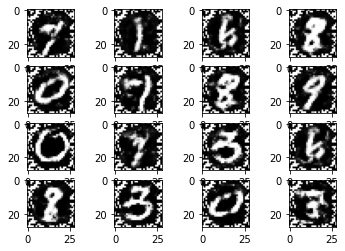

In [7]:
ckpt_fname = "CGAN-epoch=029-valid_g_loss=0.0001-valid_d_loss=4.5689.ckpt"
model = model.load_from_checkpoint("weights/CGAN/" + ckpt_fname, generator=generator, discriminator=discriminator)

with torch.no_grad():
    model.discriminator.eval()
    model.generator.eval()
    samples = model(torch.randn(16, 100), torch.randint(0, 10, (16, ))).view(-1, 1, 28, 28)
    
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()